# <b>Importance Estimation for Neural Network Pruning</b>
---
<b>Project Team</b> : V.Naveen Chander, Tejas Oturkar <br>
<b>Objective</b>    : Optimizing Convolutional Neural networks <br>
<b>Introduction</b> : This Notebook Demonstarates a framework for Optimizing CNNs. <br> 
<b>Keypoints</b>    : Importance Estimation, Iterative Training and Pruning <br>
<b>Built using</b> : Tensorflow, Keras <br>
<b>Run Time</b>     : 10 minutes 
 

## About Pruning
!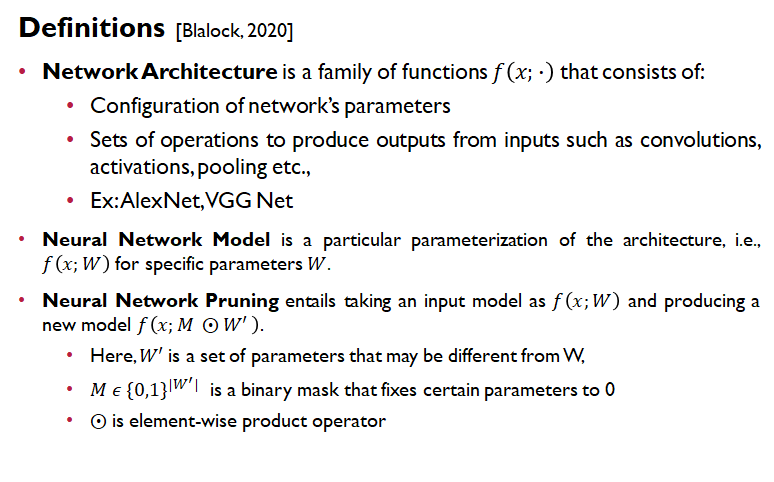

<b>CNN Architecture</b>
---
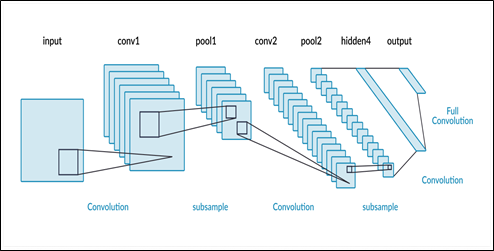

---
Convolution Layer 1: <b>32 Filters</b> <br>
Max-pooling 1 :<b>2x2</b><br>
Convolution layer 2 : <b>64 Filters</b><br>
Max-pooling 2 :<b>2x2</b><br>
Flatten      : <b>1024</b> <br>
FC Layer    : <b>10</b> <br>

<b>1. Importing Dependencies</b>

In [1]:
import tensorflow as tf
import math
from keras import layers
from keras import models
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from kerassurgeon import identify
from kerassurgeon.operations import delete_channels,delete_layer
from keras.datasets import mnist
from keras.utils import to_categorical

C:\Users\mghnv\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\mghnv\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\mghnv\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\mghnv\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

In [9]:
## Model Build Function
def build_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32,(5,5),activation='relu', input_shape=(28, 28,1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='softmax'))
    model.summary()
    return model

<b>2. Train the CNN on MNIST Handwritten Digits Dataset</b>

In [10]:
# Prepare the Dataset
from keras.datasets import mnist
from keras.utils import to_categorical
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images  = test_images.reshape((10000, 28, 28, 1))
# Normallize
train_images = train_images.astype('float32')/255
test_images  = test_images.astype('float32')/255

# Convert from Numbers (0 ->9) to Binary Classes
train_labels = to_categorical(train_labels)
test_labels  = to_categorical(test_labels)
# Build and Compile model
model = build_model()
orig_model = model  # Copy of the original model
# Train the digit classification model

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train Model
model.fit(train_images, train_labels,batch_size=100, epochs=3, validation_split=0.1)
# Evaluate MOdel
test_loss, test_acc = model.evaluate(test_images, test_labels)
#
print('first test accuracy:', test_acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                10250     
Total params: 62,346
Trainable params: 62,346
Non-trainable params: 0
_________________________________________________________________
Train 

## <b> 3. Pruning Flow </b> <br>
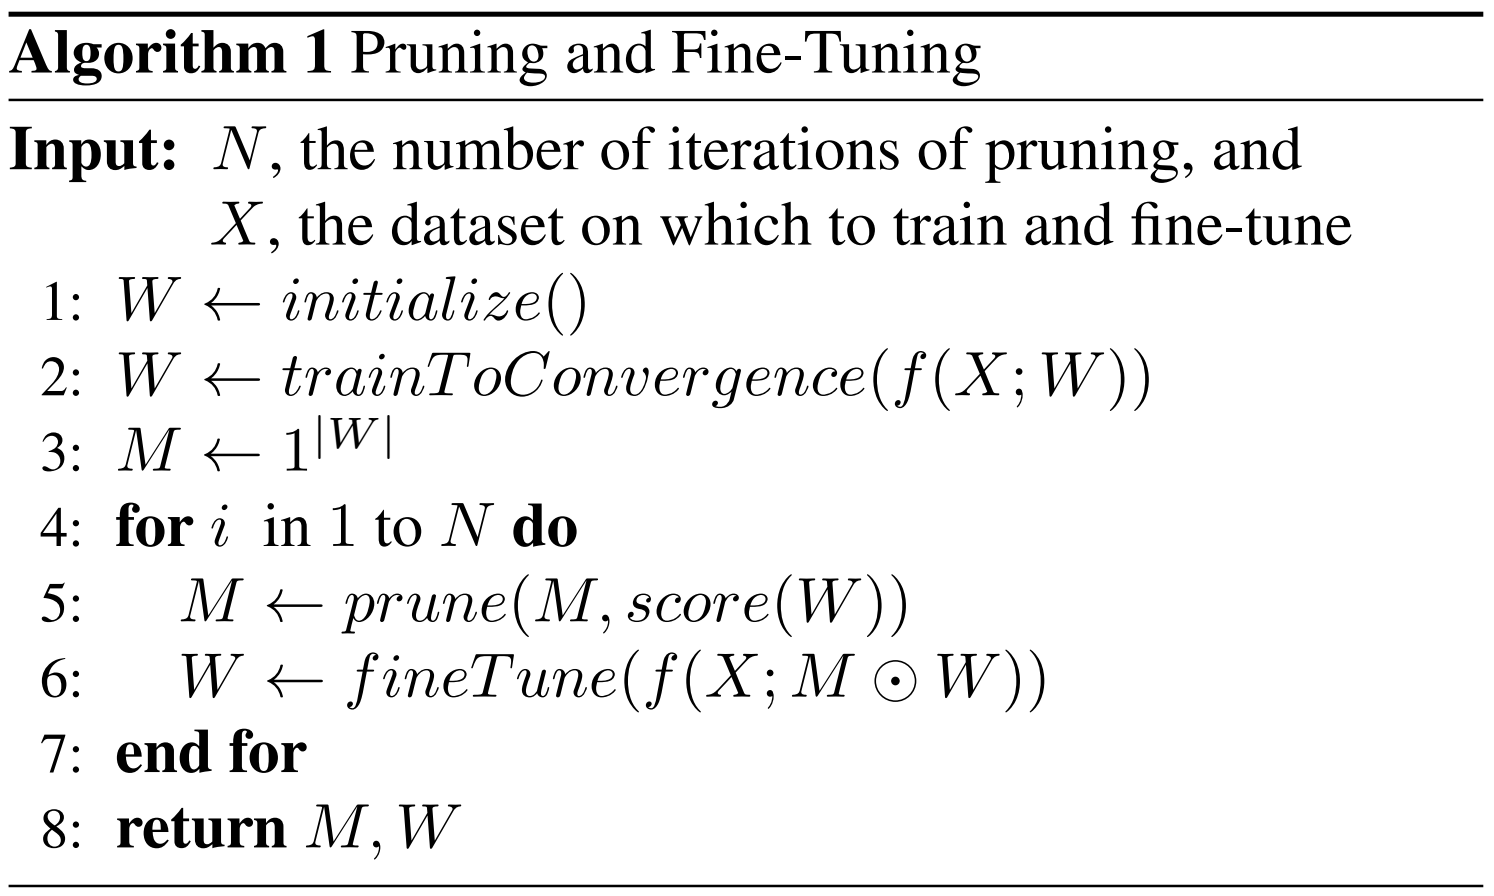
<b>Define Importance Function</b>
<b>4. Compute Importance for all Weights</b><br>
---

<font color=blue><b>Implements Importance Pruning Algorithm based on paper titled,
"Importance Estimation for Neural Netowrk Pruning", [Molchanov et.al 2019] </b><br></font>

<b>Importance of each model parameter is calculated by </br>
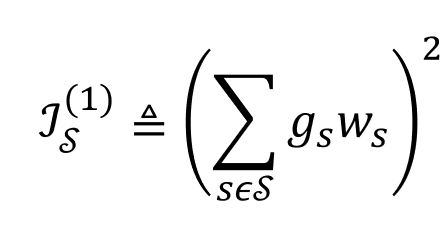
where, Im = Importance of mth model kernel in a filter <br>
gm = gradient of a model parameter w.r.t to Cost Function(Train Error)<br>
wm = Weight 

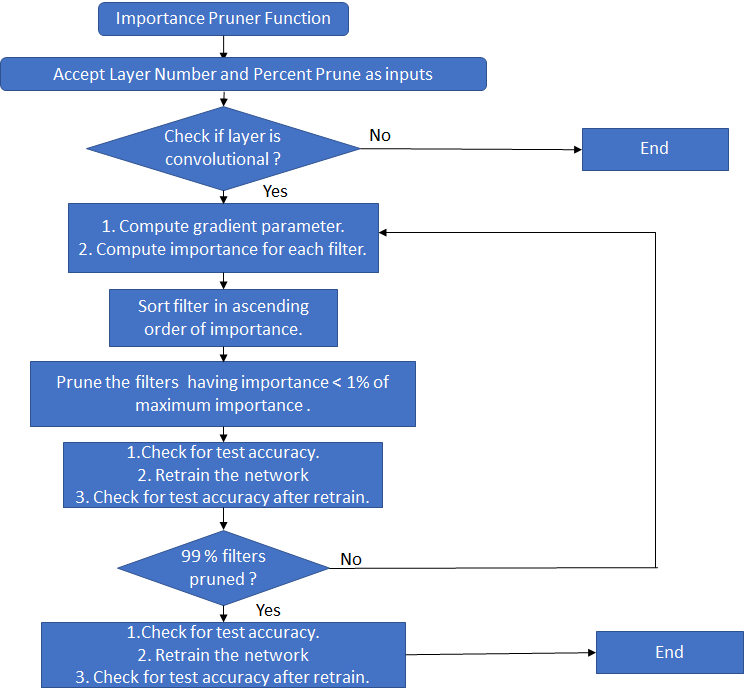

In [11]:
# Pruninig Function

def importance_prune(layer_num,filter_percent):
    '''
    Implements Importance Pruning Algorithm based on paper titled,
    --------------------------------------------------------------------------
    "Importance Estimation for Neural Netowrk Pruning", [Molchanov et.al 2019]
    --------------------------------------------------------------------------
    Inputs : 1. model : trained model
             2. layer_num : convolutional layer number to be pruned
             3. filter_percent : percentage of filters to be pruned (hyperparameter)
    '''
    #------------------------------------------------------------------------------------
    # Step 1: Check if the layer to prune is aconvoluional layer
    if model.layers[layer_num].get_config()['name'][:6]=='conv2d':
        #--------------------------------------------------------------------------------
        # Step 2: Compute Importance of Parameters in Model
        importance_dict = importance_function() ## Coded in the next cell
        #--------------------------------------------------------------------------------
        # Step 3: Sort Filters as per their ascending Importance Values
        importance_list =[('filt_{}'.format(j),\
                           importance_dict['layer_{}'.format(layer_num)][j])\
                          for j in range(model.layers[layer_num].get_config()['filters'])]
        importance_list.sort(key = lambda x: x[1])  # Sort based on 2nd element(w)
        #print(importance_list)
        #--------------------------------------------------------------------------------
        # Step 4: Identify Filters to be pruned as per given percentage
        max_imp = importance_list[-1][1]
        #filters_to_prune =[x for x in importance_list if x[1] < 0.1*max_imp]
        filter_to_prune = [ ]
        filters_to_prune = [int((x[0])[5:]) for x in \
               importance_list[:math.floor(len(importance_list)*(filter_percent/100))]]
        #--------------------------------------------------------------------------------
        # Step 5: Prune Model and store it in model_new
        model_new = delete_channels(model,\
                                    model.layers[layer_num],\
                                    filters_to_prune)
        model_new.summary()
        
        #Step 6: Compile the new Model
        #--------------------------------------------------------------------------------
        model_new.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        #Step 7: Evaluate performance of new_MODEL
        #--------------------------------------------------------------------------------
        test_loss, test_acc = model_new.evaluate(test_images, test_labels)
        
        print(f'Pruned {len(filters_to_prune)} filters from Layer {layer_num}:')
        print('Test accuracy after Pruning:',test_acc)
        #--------------------------------------------------------------------------------
        # Plot Importance of all filters in the selected layer
        #--------------------------------------------------------------------------------
       ## plt.style.use('dark_background')      
        fig = plt.figure(figsize = (10,10))
        plt.plot([x[1] for x in importance_list],marker="x",linewidth=4,label="Importance Values")
        plt.xlabel('Filter_num')
        plt.ylabel('Importance')
        plt.title("Importance Parameters sorted in ascending order",fontsize=14) 
        plt.grid(True) 
        plt.legend(loc = 'upper right')
        plt.show()
    else:
        print("Layer is Not a conv layer")
        print(model.layers[layer_num].get_config()['name'])

    return model_new, filters_to_prune, test_acc , importance_list

In [12]:
def importance_function():
    '''
    1. Computes Gradients w.r.t all trainable parameters and store in dW_np
    2. Compute Importance Function for all convolutional filters and store in  
       importance_dict{}
    '''
    np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
    #--------------------------------------------------------------------------------
    # Step 1:  Compute Gradients wrt all trainable parameters
    dW_np = compute_gradient()
    # Step 2: Compute Importance Function values for all convolutional filters
    importance_dict=compute_importance(dW_np)
    return importance_dict


In [13]:
#-----------Estimates the Importance of every Filter in a gievn conv layer------------------------------
#-------------------------------------------------------------------------------------------------------
def compute_importance(dW_np):
    len(dW_np[0])                              # 0 --> First Layer Gradients
    importance_dict ={}                        # Dict with entry for each layer
    for layer_idx in range(len(dW_np)):        # Loops through layers(6)
        if len(dW_np[layer_idx].shape)==4:     # Only if if Layer == COnv_2D
            w1 = model.layers[layer_idx].get_weights()[0]      # Layer 1 Weights (Excluding Biases)
            bias = model.layers[layer_idx].get_weights()[1]
            imp_layer = 'layer_{}'.format(layer_idx) 
            imp_matrix = np.zeros(dW_np[layer_idx].shape[3])
            for dim_1_idx in range(dW_np[layer_idx].shape[0]):  # Loops 5 times
                for dim_2_idx in range(dW_np[layer_idx].shape[1]):        # Loops 5 times
                    for dim_3_idx in range(dW_np[layer_idx].shape[2]):    # Loops 25 times ; dim_3 are filters of size 32
                        imp = np.multiply(dW_np[layer_idx][dim_1_idx][dim_2_idx][dim_3_idx],
                              w1[dim_1_idx][dim_2_idx][dim_3_idx])
                    imp_matrix+= imp
            imp_matrix+=np.multiply(bias,dW_np[layer_idx+1])
            importance_dict[imp_layer]= np.multiply(imp_matrix,imp_matrix)
    return importance_dict
#---------------------------------------------------------------------------------------------------
# Gradient Computation
#---------------------------------------------------------------------------------------------------
def compute_gradient():
    images = tf.convert_to_tensor(train_images, dtype=tf.float32)
    train_labels_tf = tf.convert_to_tensor(train_labels, dtype=tf.int64)
    logits = model(images)
    loss_value = tf.keras.backend.categorical_crossentropy(train_labels_tf,logits,from_logits=True)
    #tf.enable_eager_execution()
    grads = tf.gradients(loss_value, model.trainable_weights,unconnected_gradients='zero')
    # Initialisation operation
    init = tf.global_variables_initializer()
    # Creating a session and running the graph
    with tf.Session() as sess:
        sess.run(init)
        dW_np = sess.run(grads)
    print(f'Size of dW_np: {len(dW_np)}')
    #print(dW_np)
    return (dW_np)


<b>4. Importance Pruning in Action


Size of dW_np: 6
Deleting 32/64 channels from layer: conv2d_4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 32)          25632     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten_2 (Flatten)          multiple                  0         
_________________________________________________________________
dense_2 (Dense

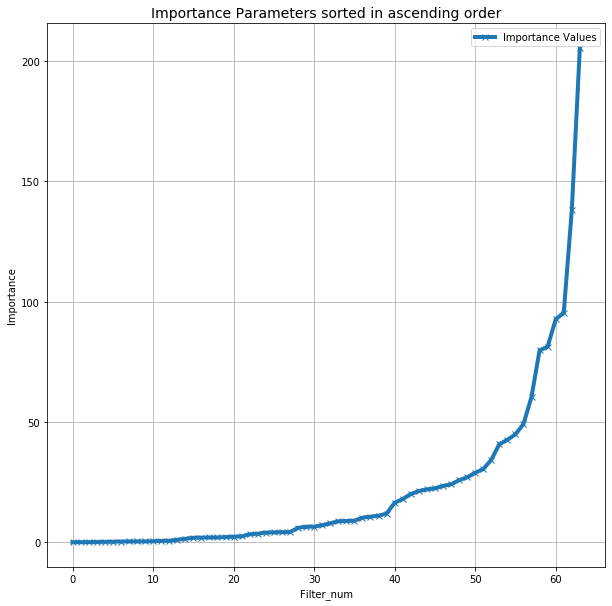

Test Accuracy Post Pruning: 0.882


In [14]:
# Call the Importance Function for Perform Importance Pruning
#---------------------------------------------------------------------------------------------------
model_new, filters_pruned, test_acc , importance_list= importance_prune(2,50)
print("Test Accuracy Post Pruning: {:.3}".format(test_acc))
#---------------------------------------------------------------------------------------------------

<Observations>
    

<b> 5. Re-training the Pruned Model

In [17]:
conv1_imp = [x[1] for x in importance_list]
cost = sum(conv1_imp)


derivative =[0.021 0.006 0.058 0.051 0.035 0.098 0.019 0.016 0.015 0.096 0.111 0.072
 0.387 0.455 0.380 0.088 0.040 0.018 0.150 0.158 0.139 0.865 0.239 0.498
 0.043 0.115 0.045 1.735 0.461 0.023 0.614 0.761 0.878 0.102 0.150 1.235
 0.428 0.398 0.877 4.500 1.540 2.068 1.288 0.658 0.434 1.025 0.650 1.709
 1.214 1.904 1.500 3.845 6.541 1.798 2.288 4.267 11.342 19.297 1.534
 11.335 2.770 42.549 67.509]
double derivative = [0.015 0.003 -0.008 -0.007 0.012 0.003 0.011 0.074 0.088 0.057 -0.005
 -0.006 -0.074 -0.061 -0.044 0.010 0.165 0.044 0.070 -0.023 -0.005 -0.164
 0.299 -0.007 -0.004 0.100 0.143 -0.171 -0.072 0.025 0.124 -0.067 -0.096
 0.155 0.870 0.061 0.328 0.178 -0.044 -0.813 -0.103 -0.284 0.084 0.111
 0.294 0.095 0.639 0.966 0.117 0.077 0.553 1.499 2.551 -0.053 1.809 -0.299
 6.241 9.642]


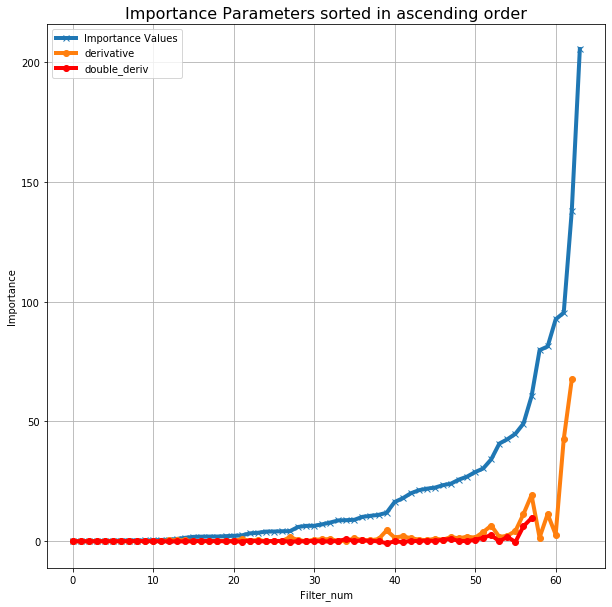

In [15]:
#max_imp = importance_list[-1][1]
#importance_list_pruned =[x for x in importance_list if x[1] < 0.1*max_imp]
#len(importance_list_pruned)

derivative=[]
for i in range(len(importance_list)-1):
    deriv = importance_list[i+1][1] - importance_list[i][1]
    derivative.append(deriv)

derivative=np.array(derivative)

deriv_avg=np.convolve(derivative, np.ones((5,))/5, mode='valid')

double_deriv = []

for i in range(len(deriv_avg)-1):
    deriv = deriv_avg[i+1] - deriv_avg[i]
    double_deriv.append(deriv)

double_deriv = np.array(double_deriv)
print('derivative ={}'.format(derivative))
print('double derivative = {}'.format(double_deriv))
fig = plt.figure(figsize = (10,10))
plt.plot([x[1] for x in importance_list],marker="x",label="Importance Values",linewidth=4)
plt.plot(derivative,marker='o',label="derivative",linewidth=4)
#plt.plot(deriv_avg,marker='o',label="deriv_avg")
plt.plot(double_deriv,marker='o',label="double_deriv",linewidth=4,color='red')

plt.xlabel('Filter_num')
plt.ylabel('Importance')
plt.title("Importance Parameters sorted in ascending order",fontsize=16) 
plt.grid(True) 
plt.legend(loc = 'upper left')
plt.show()


In [ ]:
def retrain(epochs):
    # Train
    model_new.fit(train_images, train_labels,batch_size=100, epochs=epochs, validation_split=0.1)
    # Evaluate
    test_loss, test_acc = model_new.evaluate(test_images, test_labels)
    print('Test accuracy :', test_acc)
    return test_acc

In [ ]:
retrain(1)

<b> Carry Out Pruning and Retraining Iteratively till the required accuracy is reached</b>

# RESULTS
Plot shows the Result of 10 iterations
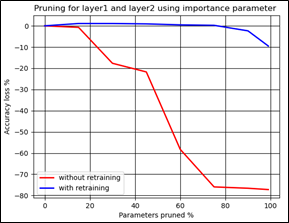

# Comparison with other Structural Pruning Methods
Here we compare the results of Importance Pruning with the L1_norm Structural Pruning as given in [Deng. et al 2017]

In [18]:
# Pruning Function
from keras.models import model_from_json
import keras
class l0_pruner:  # Name COrrection to l1_norm
    def __init__(self,layer_num,prune_percent,epoch=5):
        self.layer_num = layer_num
        self.prune_percent = prune_percent
        self.epoch = epoch
        
    def sort_weights(self):
        self.weight = model.layers[self.layer_num].get_weights()[0]
        self.num_filters = len(self.weight[0,0,0,:])
        #Compute the L1 Norm of each filter and store it in a list of tules: (filt_i,l1_norm(i))
        self.l1_norm_list =[('filt_{}'.format(j),np.sum(abs(self.weight[:,:,:,j]))) \
                       for j in range(self.num_filters)]
        # Sort Filters as per their ascending L1 val
        self.l1_norm_list.sort(key = lambda x: x[1])  # Sort based on 2nd element(w)
        return self.l1_norm_list

        #weights_dict_sort=sorted(weights_dict.items(),key=lambda kv: kv[1])
    def plot_l1_norms(self):
        #plt.style.use('dark_background')      
        #plt.figure(self.num_layer+1,figsize=(7,5))
        plt.plot([x[1] for x in self.l1_norm_list])
        plt.xlabel('Filter_num')
        plt.ylabel('LI Norm')
        plt.title('Conv_layer {}'.format(self.layer_num+1))
        plt.grid(True)    
        
    def surgeon(self):
        self.filters_to_prune = \
        [int((x[0])[5:]) for x in \
        self.l1_norm_list[:math.floor(len(self.l1_norm_list)*(self.prune_percent/100))]]
        model_new = delete_channels(model,\
                                    model.layers[self.layer_num],\
                                    self.filters_to_prune)
        model_new.summary()
        return model_new , self.l1_norm_list


In [19]:
# Pruninig Function
def prune_filter(model,layer_num,filter_percent):
    # Creat an instance of the input model
    config = model.get_config()
    model_bkup = models.Sequential.from_config(config)
    
    # Compute Gradients and Importance Functions
    #dW_np = compute_gradient()
    # COmpute Importance Function
    np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
    #importance_dict=compute_importance(dW_np)

    if model.layers[layer_num].get_config()['name'][:6]=='conv2d':
        pruner=l0_pruner(layer_num,filter_percent)
        pruner.sort_weights()
        pruner.plot_l1_norms()
        model_new , pruned_filters = pruner.surgeon()
        # model is updated with pruned model
        config = model_new.get_config()
        model = model_new            
        # Compile New model
        model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

        # Evaluate Pruned model
        test_loss, test_acc = model.evaluate(test_images, test_labels)
        print(f'Pruned {len(pruned_filters)} filters from Layer {layer_num}:')
        print('Test accuracy after Pruning:',test_acc)
    else:
        print("Layer is Not a conv layer")
        print(model.layers[layer_num].get_config()['name'])
    return model, pruned_filters, test_acc

def retrain(epochs):
    # Train
    # Train Model
    model.fit(train_images, train_labels,batch_size=100, epochs=3, validation_split=0.1)
    # Evaluate
    test_loss, test_acc = model_new.evaluate(test_images, test_labels)
    print('Test accuracy :', test_acc)
    return test_acc


Deleting 32/64 channels from layer: conv2d_4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 32)          25632     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten_2 (Flatten)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              (N

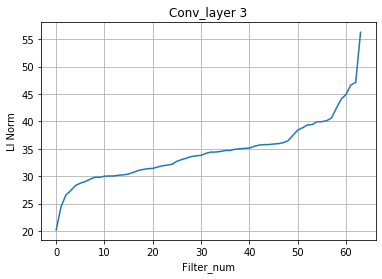

In [20]:
#prune_1=l0_pruner(model,2,10,1)
#prune_1.prune_filter()
model, pruned_filters, test_acc = prune_filter(model,2,50)
# Paramters : Model Name to be pruned, LayerNum= 2, Prune_percent = 50

In [ ]:
model=orig_model
model.summary()

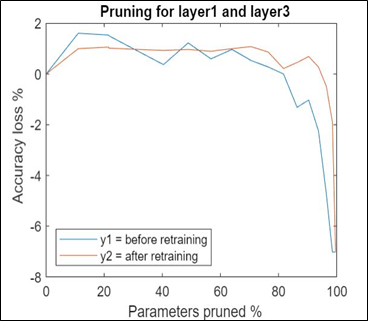

In [ ]:
images = tf.convert_to_tensor(train_images, dtype=tf.float32)
train_labels_tf = tf.convert_to_tensor(train_labels, dtype=tf.int64)
logits = model(images)
loss_value = tf.keras.backend.categorical_crossentropy(train_labels_tf,logits,from_logits=True)

In [ ]:
train_labels_tf.get_shape

In [ ]:
# Pruning Function
#from keras.models import model_from_json
#import keras
#config = model_new.get_config()
#json_string = model.to_json()
model_new, filters_pruned, test_acc = importance_prune(2,50)
# paramters =layer_no and Prune_percent

In [ ]:
retrain(3) # argument = no.ofepochs

In [ ]:
import keras as k

In [ ]:
k.__version__